In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
import sklearn
print(sklearn.__version__)

1.1.1


In [3]:
# ! pip install catboost

In [4]:
# ! pip install xgboost

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, \
                                  LabelEncoder, OrdinalEncoder, \
                                  OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, \
                                    StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost.utils import eval_metric
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, \
                            confusion_matrix, plot_confusion_matrix, \
                            classification_report, make_scorer, \
                            roc_auc_score, roc_curve, \
                            precision_recall_curve, auc
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import chi2_contingency, binom_test

In [6]:
# ! pip install imblearn

In [7]:
sns.set()

sns.set_style("darkgrid")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)  
pd.options.display.max_rows = 500

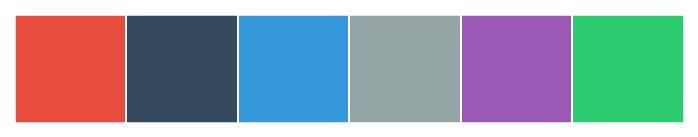

In [9]:
flatui = ["#e74c3c", "#34495e", "#3498db", "#95a5a6", "#9b59b6", "#2ecc71"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))

## $\S$1. Feature Selection

#### 1-1. Data

In [11]:
df = pd.read_csv('./marlette-ds-challenge-main/training_data.csv').set_index('ID')
df.drop_duplicates(inplace=True)

In [12]:
df.shape

(14193, 198)

* Highly imbalanced:

In [13]:
df['target'].value_counts(normalize=True) * 100

0    99.055873
1     0.944127
Name: target, dtype: float64

#### 1-2. Raw distributions of numerical data

In [14]:
def plot_multiple_histograms(df, ncols, bins=30, alpha=0.5,
                             density=True, figscale=4):
    '''
    '''
    nrows = math.ceil(df.shape[1] / ncols)
    if nrows == 1:
        ncols -= 1
        nrows = math.ceil(df.shape[1] / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(ncols*figscale, nrows*figscale))
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]
            if counter < len(df.columns):
                ax.hist(df[df.columns[counter]],
                        bins=bins,
                        alpha=alpha,
                        density=density,
                        label='{}'.format(df.columns[counter]))
                ax.tick_params(axis='x', labelsize=10)
                ax.tick_params(axis='y', labelsize=10)
                ax.set_ylabel('PDF')
                leg = ax.legend(loc='upper left', prop={'size': 15})
                leg.draw_frame(False)
            else:
                ax.set_axis_off()
            counter += 1
    plt.show();

In [15]:
numerical_data = df.iloc[:, :192]
categorical_data = df.iloc[:, 192:-1]

In [16]:
# plot_multiple_histograms(numerical_data, ncols=5)

#### 1-3. Eliminate outliers from variables `'var154'` - `'var169'`
* `'var154'` - `'var169'` have high outlier occurrences at `-999.0`.  
* The class balance shows virtually no change after the records with `-999.0` are eliminated; 
hence those records have little importance in the problem:

In [17]:
len(pd.concat([numerical_data.iloc[:, 152:169].replace(-999.0, np.nan), df['target']], axis=1).dropna()) / len(df) * 100

87.5361093496794

In [18]:
pd.concat([numerical_data.iloc[:, 152:169].replace(-999.0, np.nan), df['target']], axis=1).dropna()['target'].value_counts(normalize=True) * 100

0    98.953638
1     1.046362
Name: target, dtype: float64

In [19]:
df['target'].value_counts(normalize=True) * 100

0    99.055873
1     0.944127
Name: target, dtype: float64

In [20]:
numerical_data.iloc[:, 152:169] = numerical_data.iloc[:, 152:169].replace(-999.0, np.nan)

#### 1-4. Pearson correlations in numerical data

* Take a somewhat aggressive threshold value, given the relatively small data size.

In [21]:
corr_matrix = numerical_data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

In [22]:
correlation_threshold = 0.8
to_be_dropped = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]

In [23]:
numerical_data = numerical_data.drop(columns=to_be_dropped, axis=1)
numerical_data.shape

(14193, 6)

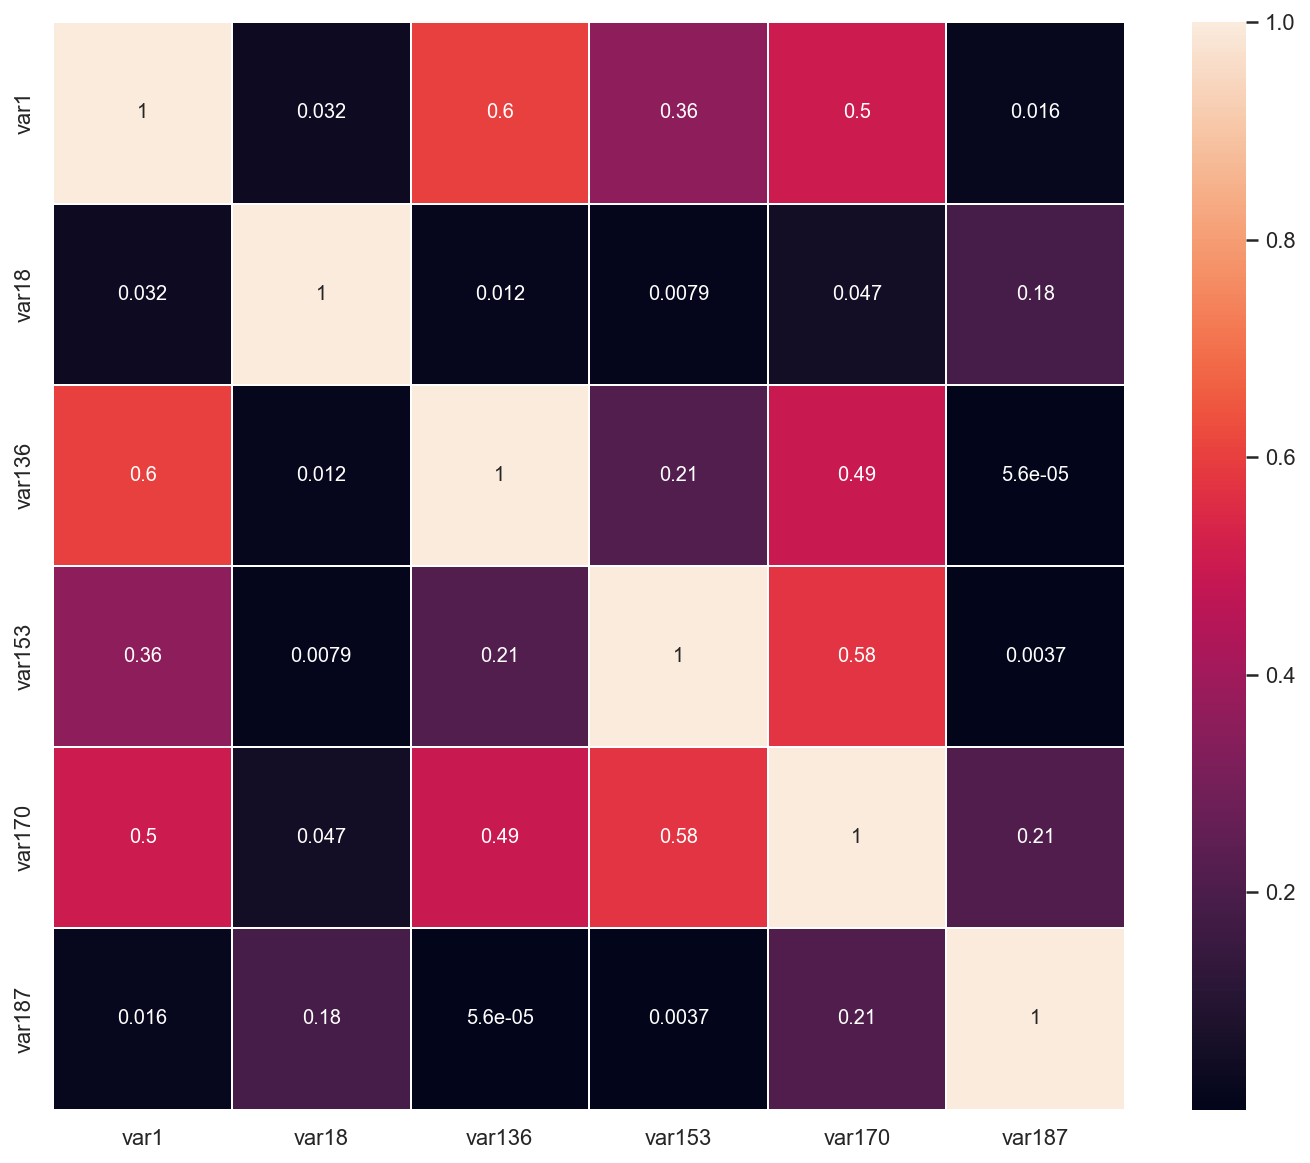

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_data.corr().abs(), square=False, annot=True, linewidth=1);

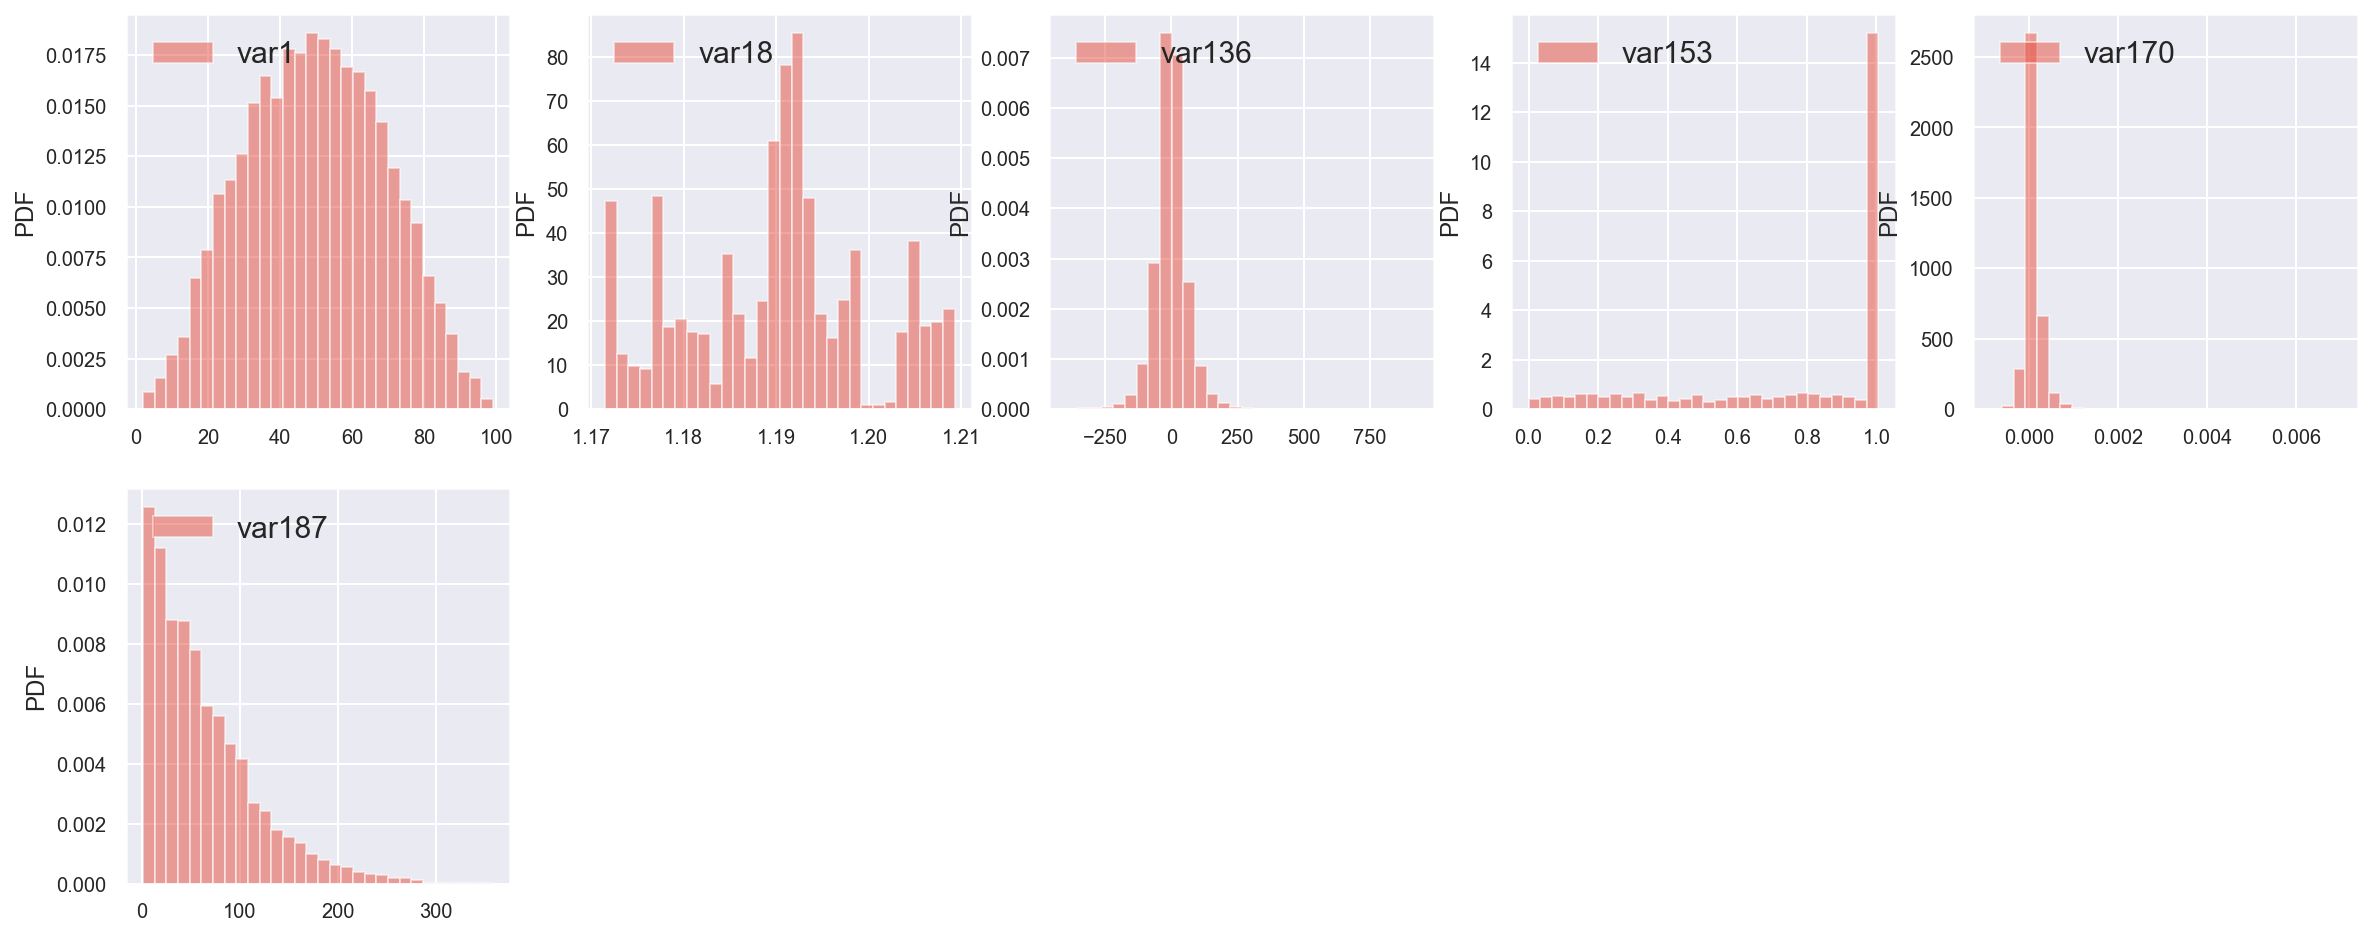

In [25]:
plot_multiple_histograms(numerical_data, ncols=5)

* Log transform `'var187'`:

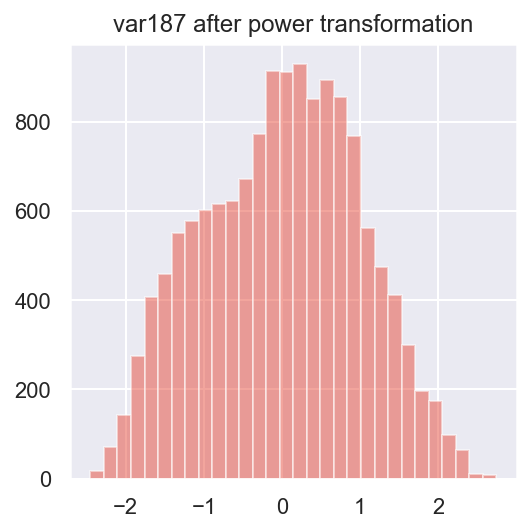

In [26]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
pd.DataFrame(power.fit_transform(pd.DataFrame(numerical_data['var187'])),
             columns=['var187 after power transformation']).hist(bins=30, alpha=0.5, figsize=(4, 4));

#### 1-5. Chi-square test on categorical data

* We only retain `'cat2'` and `'cat5'` whose p-values are less than the statistical significant level of 0.05.

In [27]:
def categorical_chi2(df, stat_sig=0.05):
    cols = []
    for col in df.columns:
        if col!='target':
            crosstab_res = pd.crosstab(index=df[col], columns=df['target'])
            chi2_res = chi2_contingency(crosstab_res)
            print(col, ': p-value=', chi2_res[1])
            if chi2_res[1] < stat_sig:
                cols.append(col)
    return cols

In [28]:
categorical_data = categorical_data[categorical_chi2(pd.concat([categorical_data, df['target']], axis=1))]

cat1 : p-value= 0.36634684518654326
cat2 : p-value= 1.5254937362411916e-17
cat3 : p-value= 0.8319330730716096
cat4 : p-value= 0.136965436184928
cat5 : p-value= 4.819245700531303e-18


## $\S$2. Data Preprocessing

In [29]:
def trim_inputs(X_train, X_test, y_train, y_test, cols_trim, threshold=3):
    '''
    Eliminate values beyond 3 sigma.
    '''
    if len(cols_trim) == 0: return X_train, X_test, y_train, y_test
    X_train = X_train.copy()
    X_test = X_test.copy()
    for col in cols_trim:
        mean = X_train[col].mean()
        std = X_train[col].std()
        cutoff = std * threshold
        lower, upper = mean - cutoff, mean + cutoff
        X_train.loc[:, col] = X_train[(X_train[col] > lower) & (X_train[col] < upper)].loc[:, col]
        X_test.loc[:, col] = X_test[(X_test[col] > lower) & (X_test[col] < upper)].loc[:, col]
    df_train = pd.concat([X_train, y_train], axis=1).dropna()
    df_test = pd.concat([X_test, y_test], axis=1).dropna()
    return df_train.iloc[:, :-1], df_test.iloc[:, :-1], df_train.iloc[:, -1], df_test.iloc[:, -1]

In [30]:
def scale_inputs(X_train, X_test):
    scl = StandardScaler()
    # scl = MinMaxScaler()
    scl.fit(X_train)
    X_train_scl = scl.transform(X_train)
    X_test_scl  = scl.transform(X_test)
    return X_train_scl, X_test_scl

In [31]:
def power_inputs(X_train, X_test, method='yeo-johnson', standardize=True):
    pwr = PowerTransformer(method=method, standardize=standardize)
    pwr.fit(X_train)
    X_train_pwr = pwr.transform(X_train)
    X_test_pwr  = pwr.transform(X_test)
    return X_train_pwr, X_test_pwr

In [32]:
def ordinal_encode_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc  = oe.transform(X_test)
    return X_train_enc, X_test_enc

In [33]:
def onehot_encode_inputs(X_train, X_test):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc  = ohe.transform(X_test)
    return X_train_enc, X_test_enc

In [34]:
def label_encode_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc  = le.transform(y_test)
    return y_train_enc, y_test_enc

In [35]:
def transform_data(X_train, X_test, y_train, y_test, cols_trim,
                   cols_scale, cols_power, cols_onehot_encode):
    # Eliminate outliers before scaling
    X_train, X_test, y_train, y_test = trim_inputs(X_train, X_test, y_train, y_test, cols_trim)
    
    X_train_trf, X_test_trf = scale_inputs(X_train[cols_scale], X_test[cols_scale])  

    if len(cols_power):
        X_train_pwr, X_test_pwr = power_inputs(X_train[cols_power], X_test[cols_power])
        X_train_trf = np.concatenate([X_train_trf, X_train_pwr], axis=1)
        X_test_trf = np.concatenate([X_test_trf, X_test_pwr], axis=1)
        
    if len(cols_onehot_encode):
        X_train_enc, X_test_enc = onehot_encode_inputs(X_train[cols_onehot_encode],
                                                       X_test[cols_onehot_encode])
        X_train_trf = np.concatenate([X_train_trf, X_train_enc], axis=1)
        X_test_trf = np.concatenate([X_test_trf, X_test_enc], axis=1)    
        
    y_train_enc, y_test_enc = label_encode_targets(y_train, y_test)
    
    return X_train_trf, X_test_trf, y_train_enc, y_test_enc

In [36]:
# For correlation_threshold = 0.8:
cols_trim  = ['var1', 'var18', 'var136', 'var170']
cols_scale = ['var1', 'var18', 'var136', 'var153', 'var170']
# For correlation_threshold = 0.9:
# cols_trim = ['var1', 'var18', 'var105', 'var106', 'var121', 'var136', 'var137', 'var170', 'var171', 'var182']
# cols_scale = ['var1', 'var18', 'var105', 'var106', 'var121', 'var136', 'var137', 'var170', 'var171', 'var182',
#               'var101', 'var102', 'var153']
cols_power = ['var187']
cols_onehot_encode = ['cat2', 'cat5']

## $\S$3. Models

In [37]:
def get_models(clf_name):
    if clf_name == 'LR':
        clf = LogisticRegression()
    elif clf_name == 'CBT':
        clf = CatBoostClassifier()
    elif clf_name == 'XGB':
        clf = XGBClassifier()
        
    param_grid_clf = param_grid[clf_name]
    
    return clf, param_grid_clf

In [38]:
def pr_auc(y_test, y_pred_proba):
    p, r, _ = precision_recall_curve(y_test, y_pred_proba)
    return auc(r, p)

In [39]:
def evaluate_model(X, y, estimator, param_grid,
                   scorer=None, refit=None,
                   n_splits=5, n_jobs=-1):
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits,
                                 n_repeats=n_repeats,
                                 random_state=seed)
    
    clf_cv = GridSearchCV(estimator=estimator,
                          param_grid=param_grid,
                          scoring=scorer,
                          cv=cv,
                          refit=refit_score,
                          return_train_score=True,
                          n_jobs=n_jobs)
    clf_cv.fit(X, y)
    return clf_cv

In [40]:
def models(classifiers, scorer, refit_score, resampling):
    
    data = pd.concat([numerical_data, categorical_data, df['target']], axis=1)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    print('Original minority fraction: {:.2f}%'.format(y.sum() / len(y) * 100))
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.33,
                                                        stratify=y,
                                                        shuffle=True,
                                                        random_state=seed)
    print('After train-test split: train {:.2f}%, test {:.2f}%'.format(y_train.sum() \
          / len(y_train) * 100, y_test.sum() / len(y_test) * 100))
    
    # Tranform
    X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test,
                                                      cols_trim=cols_trim,
                                                      cols_scale=cols_scale,
                                                      cols_power=cols_power,
                                                      cols_onehot_encode=cols_onehot_encode)
    print('After transformation: train {:.2f}%, test {:.2f}%'.format(y_train.sum() / \
          len(y_train) * 100, y_test.sum() / len(y_test) * 100))
    
    # Resampling
    if resampling is None:
        pass
    else:
        if resampling == 'ROS':
            rs = RandomOverSampler(random_state=seed) 
        elif resampling == 'RUS':
            rs = RandomUnderSampler(random_state=seed)
        elif resampling == 'SMOTE':
            rs = SMOTE(random_state=seed)
        X_train, y_train = rs.fit_resample(X_train, y_train)
        print('After resampling: train {:.2f}%, test {:.2f}%'.format(y_train.sum() / \
              len(y_train) * 100, y_test.sum() / len(y_test) * 100))
        
    for c in classifiers:
        clf, param_grid_clf = get_models(c)

        # Grid search CV to optimize for refit_score
        clf_cv = evaluate_model(X_train, y_train,
                                estimator=clf,
                                param_grid=param_grid_clf,
                                scorer=scorer,
                                refit=refit_score,
                                n_splits=n_splits,
                                n_jobs=n_jobs)

        # Redefine clf as the best estimator
        clf = clf_cv.best_estimator_
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:, 1]

        # ROC curve
        fpr_c, tpr_c, th_roc_c = roc_curve(y_test, y_score)
        # P-R curve
        precision_c, recall_c, th_pr_c = precision_recall_curve(y_test, y_score)
        ix_pr_c = np.argmax(precision_c[:-1]) # Index of threshold at the highest precision

        print('\n******************* {} *******************'.format(clf.__class__.__name__))
        print('Best hyper-params: {}'.format(clf_cv.best_params_))
        print('Refit score: {}'.format(refit_score))
        print('Best score: {:.2f}'.format(clf_cv.best_score_))
        print('\nClassification report: ')
        print(classification_report(y_test, y_pred, zero_division=0))
        print('Confusion matrix: ')
        print(confusion_matrix(y_test, y_pred), '\n')
        print('\nROC AUC score: {:.2f}'.format(roc_auc_score(y_test, y_score)))
        print('P-R AUC score: {:.2f}'.format(auc(recall_c, precision_c)))
        # print('Threshold for the highest precision: {:.2f}\n'.format(th_pr_c[ix_pr_c]))

        # ROC curve
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        ax = axes[0]
        ax.plot(fpr_c, tpr_c, marker='.', label=str(c))
        ax.plot([0, 1], [0, 1], linestyle='--', label="Random")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()

        # P-R curve
        ax1 = axes[1]
        random = len(y_test[y_test==1]) / len(y_test)
        ax1.plot(recall_c[:-1], precision_c[:-1], marker='.', label=str(c))
        # ax1.scatter(recall_c[ix_pr_c], precision_c[ix_pr_c], marker='o', color='black', label='Th. at highest precision')
        ax1.plot([0, 1], [random, random], linestyle='--', label="Random")
        ax1.set_xlabel("Recall")
        ax1.set_ylabel("Precision")
        ax1.legend()

        plt.show()
        
    return 

In [41]:
classifiers = [
               'LR',
               'CBT',
               'XGB',
              ]
n_splits = 5
n_repeats = 2
seed = 42
n_jobs = -1

In [42]:
param_grid = {'LR': {
                     'penalty':[
                                #'l1',
                                'l2',
                               ],
                     'solver':[
                                 #'newton-cg',
                                 #'lbfgs',
                                 'liblinear',
                                ],
                     'C':np.logspace(-2, 1, 100),
                     'max_iter':[
                                 1000,
                                 100000,
                                 ],
                     'class_weight':[
                                     #None,
                                     'balanced',
                                    ],
                     'verbose':[0]
                     },
              'CBT': {
                      'silent':[True],
                      'depth': [4, 6, 8],
                      'iterations': [500, 1000, 2000],
                      'l2_leaf_reg': [1, 2, 3],
                      'learning_rate': [0.02, 0.04],
                      #'loss_function':['Logloss'],
                     },
              'XGB': {
                      'learning_rate':[0.1],
                      'n_estimators':[1000],
                      'max_depth':[3,5],
                      'min_child_weight':[1,2,3],
                      'gamma':[0,3,10],
                      'max_delta_step':[5],
                      'objective':['binary:logistic'],
                      'scale_pos_weight':[1, 50, 105],
                      #'eval_metric':None,
                     },
             }

#### 3-1. Plain models
* ROC AUC score as an evaluation metric (`scoring` and `refit_score` in `GridSearchCV()`); no resampling of train data.

In [43]:
scorer = {
           #'accuracy_score': make_scorer(accuracy_score, greater_is_better=True),
           #'precision_score': make_scorer(precision_score, greater_is_better=True),
           #'recall_score': make_scorer(recall_score, greater_is_better=False),
           #'f1_score':make_scorer(f1_score, greater_is_better=True),
           'roc_auc_score': make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True),
           #'pr_score': make_scorer(pr_auc, needs_proba=True, greater_is_better=True),
          }

refit_score = 'roc_auc_score'
resampling = None

Original minority fraction: 0.94%
After train-test split: train 0.95%, test 0.94%
After transformation: train 0.93%, test 0.87%

******************* LogisticRegression *******************
Best hyper-params: {'C': 0.06579332246575682, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'verbose': 0}
Refit score: roc_auc_score
Best score: 0.92

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      4532
           1       0.05      0.95      0.09        40

    accuracy                           0.84      4572
   macro avg       0.52      0.89      0.50      4572
weighted avg       0.99      0.84      0.90      4572

Confusion matrix: 
[[3796  736]
 [   2   38]] 


ROC AUC score: 0.95
P-R AUC score: 0.11


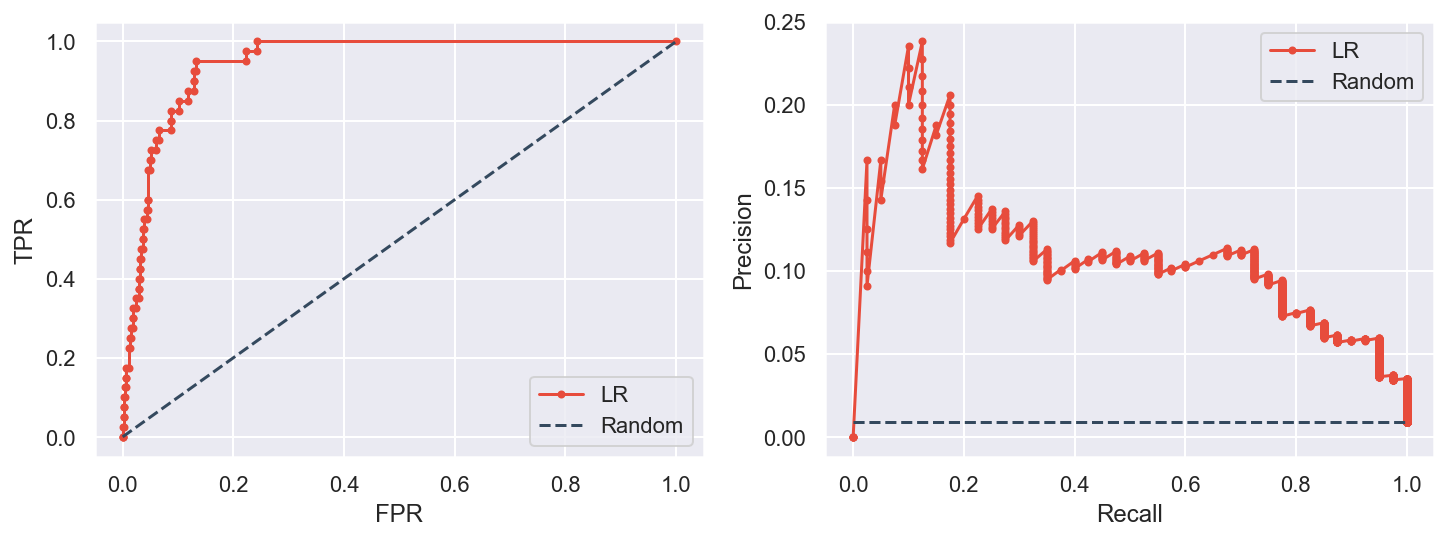


******************* CatBoostClassifier *******************
Best hyper-params: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.02, 'silent': True}
Refit score: roc_auc_score
Best score: 0.90

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4532
           1       0.00      0.00      0.00        40

    accuracy                           0.99      4572
   macro avg       0.50      0.50      0.50      4572
weighted avg       0.98      0.99      0.99      4572

Confusion matrix: 
[[4532    0]
 [  40    0]] 


ROC AUC score: 0.94
P-R AUC score: 0.12


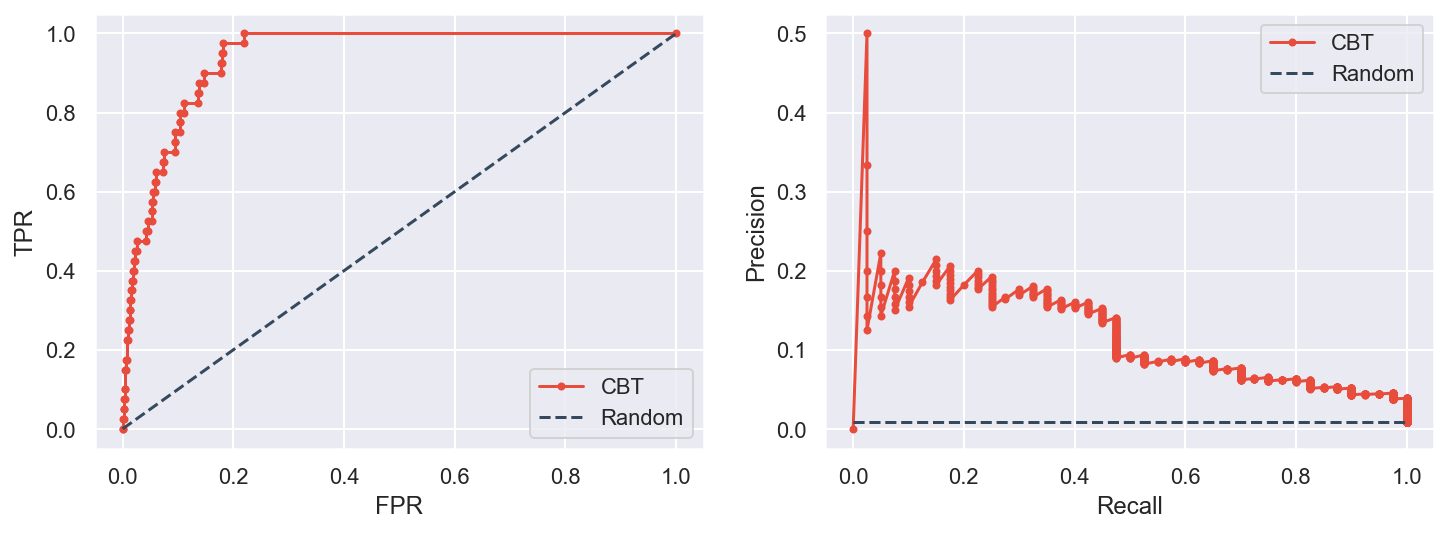


******************* XGBClassifier *******************
Best hyper-params: {'gamma': 3, 'learning_rate': 0.1, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1}
Refit score: roc_auc_score
Best score: 0.90

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4532
           1       0.00      0.00      0.00        40

    accuracy                           0.99      4572
   macro avg       0.50      0.50      0.50      4572
weighted avg       0.98      0.99      0.99      4572

Confusion matrix: 
[[4532    0]
 [  40    0]] 


ROC AUC score: 0.94
P-R AUC score: 0.10


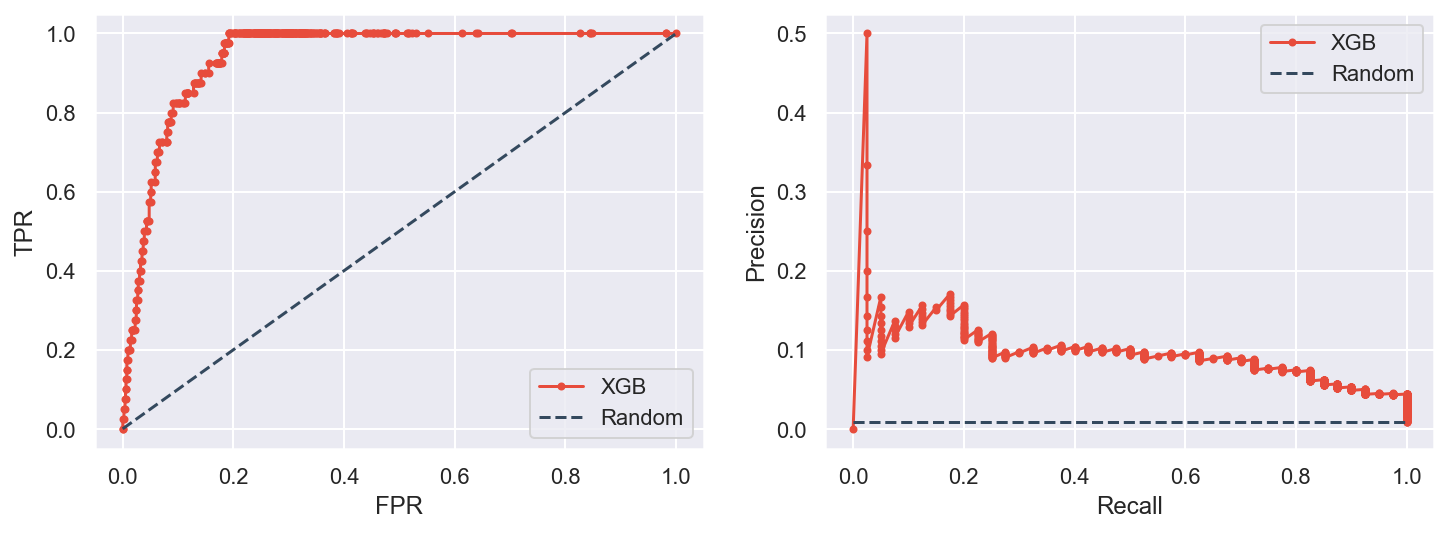

In [44]:
models(classifiers, scorer, refit_score, resampling)

#### 3-2. Optimized for precision
* Precision and P-R AUC score for `scoring` and precision for `refit_score`; no resampling of train data.

In [45]:
scorer = {
           #'accuracy_score': make_scorer(accuracy_score, greater_is_better=True),
           'precision_score': make_scorer(precision_score, greater_is_better=True),
           #'recall_score': make_scorer(recall_score, greater_is_better=False),
           #'f1_score':make_scorer(f1_score, greater_is_better=True),
           #'roc_auc_score': make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True),
           'pr_score': make_scorer(pr_auc, needs_proba=True, greater_is_better=True),
          }

refit_score = 'precision_score'
resampling = None

Original minority fraction: 0.94%
After train-test split: train 0.95%, test 0.94%
After transformation: train 0.93%, test 0.87%

******************* LogisticRegression *******************
Best hyper-params: {'C': 0.21544346900318845, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'verbose': 0}
Refit score: precision_score
Best score: 0.05

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      4532
           1       0.05      0.93      0.09        40

    accuracy                           0.84      4572
   macro avg       0.52      0.88      0.50      4572
weighted avg       0.99      0.84      0.91      4572

Confusion matrix: 
[[3816  716]
 [   3   37]] 


ROC AUC score: 0.95
P-R AUC score: 0.12


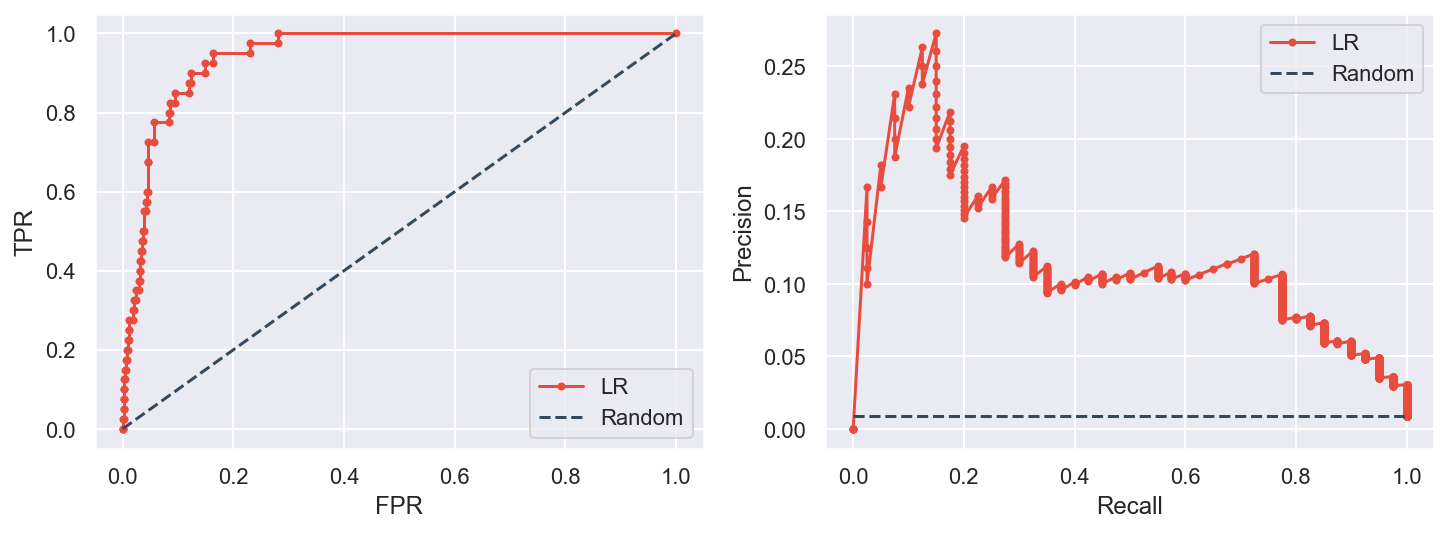

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification


******************* CatBoostClassifier *******************
Best hyper-params: {'depth': 4, 'iterations': 2000, 'l2_leaf_reg': 1, 'learning_rate': 0.04, 'silent': True}
Refit score: precision_score
Best score: 0.05

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4532
           1       0.00      0.00      0.00        40

    accuracy                           0.99      4572
   macro avg       0.50      0.50      0.50      4572
weighted avg       0.98      0.99      0.99      4572

Confusion matrix: 
[[4528    4]
 [  40    0]] 


ROC AUC score: 0.90
P-R AUC score: 0.10


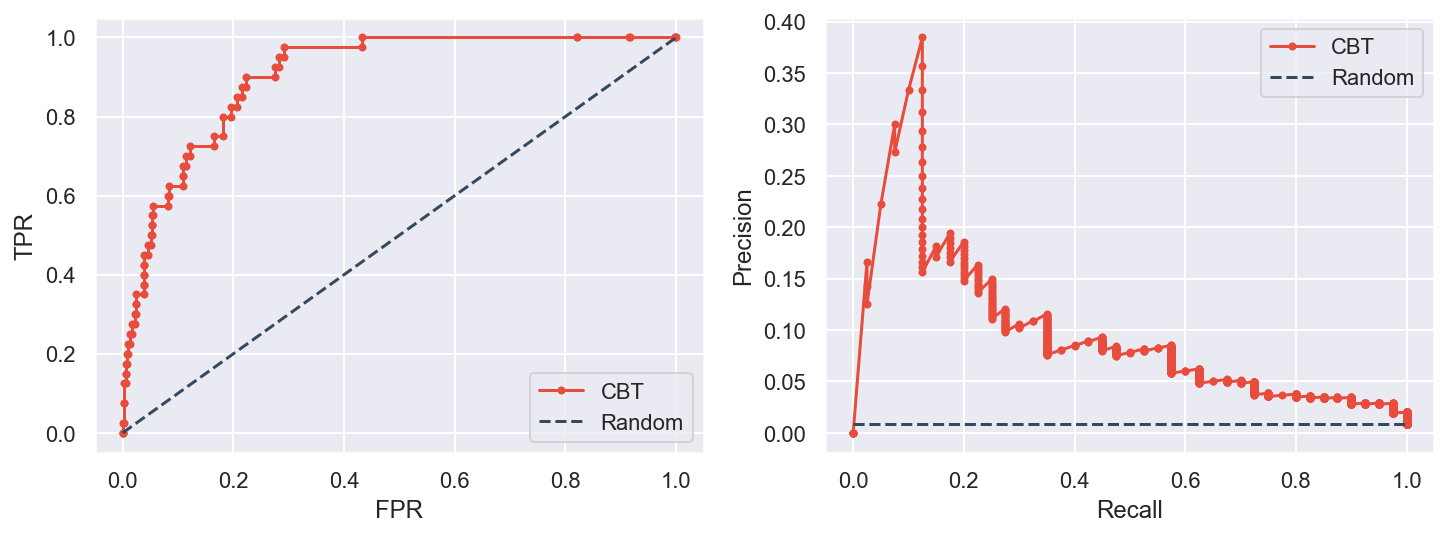

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification

/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leet/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification


******************* XGBClassifier *******************
Best hyper-params: {'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1}
Refit score: precision_score
Best score: 0.28

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4532
           1       0.20      0.03      0.04        40

    accuracy                           0.99      4572
   macro avg       0.60      0.51      0.52      4572
weighted avg       0.98      0.99      0.99      4572

Confusion matrix: 
[[4528    4]
 [  39    1]] 


ROC AUC score: 0.90
P-R AUC score: 0.07


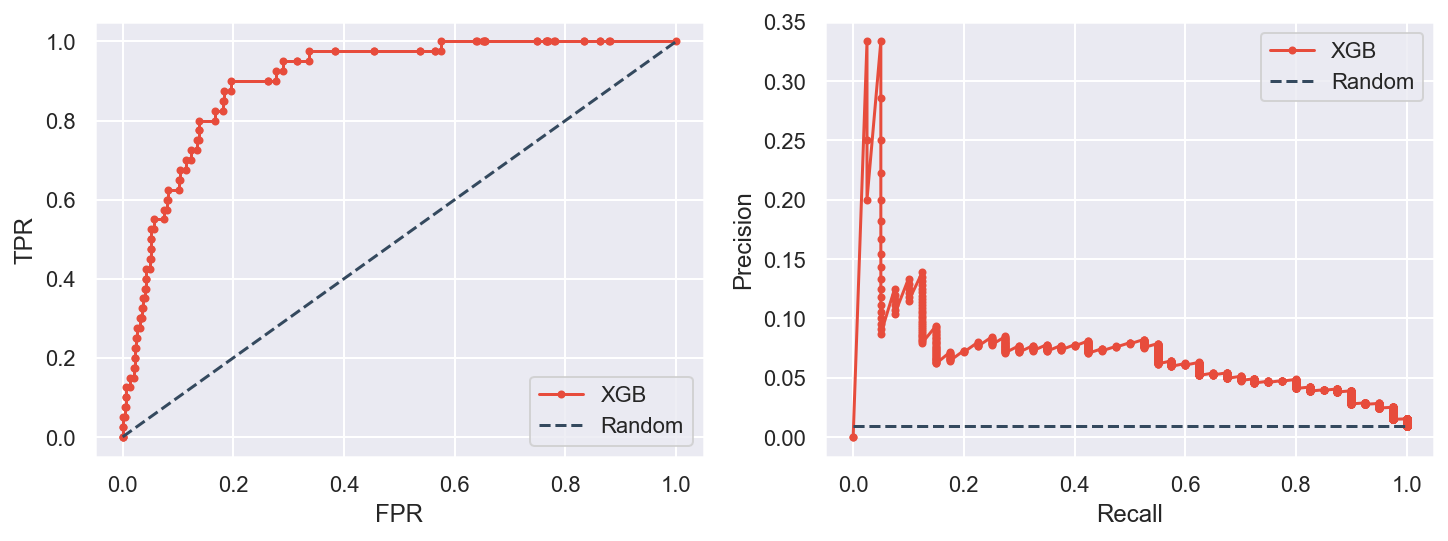

In [46]:
models(classifiers, scorer, refit_score, resampling)

#### 3-3. Optimized for precision and resampling train data with SMOTE
* Precision and P-R AUC score for `scoring` and precision for `refit_score`; apply SMOTE on train data.

In [47]:
scorer = {
           #'accuracy_score': make_scorer(accuracy_score, greater_is_better=True),
           'precision_score': make_scorer(precision_score, greater_is_better=True),
           #'recall_score': make_scorer(recall_score, greater_is_better=False),
           #'f1_score':make_scorer(f1_score, greater_is_better=True),
           #'roc_auc_score': make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True),
           'pr_score': make_scorer(pr_auc, needs_proba=True, greater_is_better=True),
          }

refit_score = 'precision_score'
resampling = 'SMOTE'

Original minority fraction: 0.94%
After train-test split: train 0.95%, test 0.94%
After transformation: train 0.93%, test 0.87%
After resampling: train 50.00%, test 0.87%

******************* LogisticRegression *******************
Best hyper-params: {'C': 9.326033468832199, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'verbose': 0}
Refit score: precision_score
Best score: 0.86

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      4532
           1       0.05      0.90      0.10        40

    accuracy                           0.86      4572
   macro avg       0.53      0.88      0.51      4572
weighted avg       0.99      0.86      0.92      4572

Confusion matrix: 
[[3891  641]
 [   4   36]] 


ROC AUC score: 0.94
P-R AUC score: 0.12


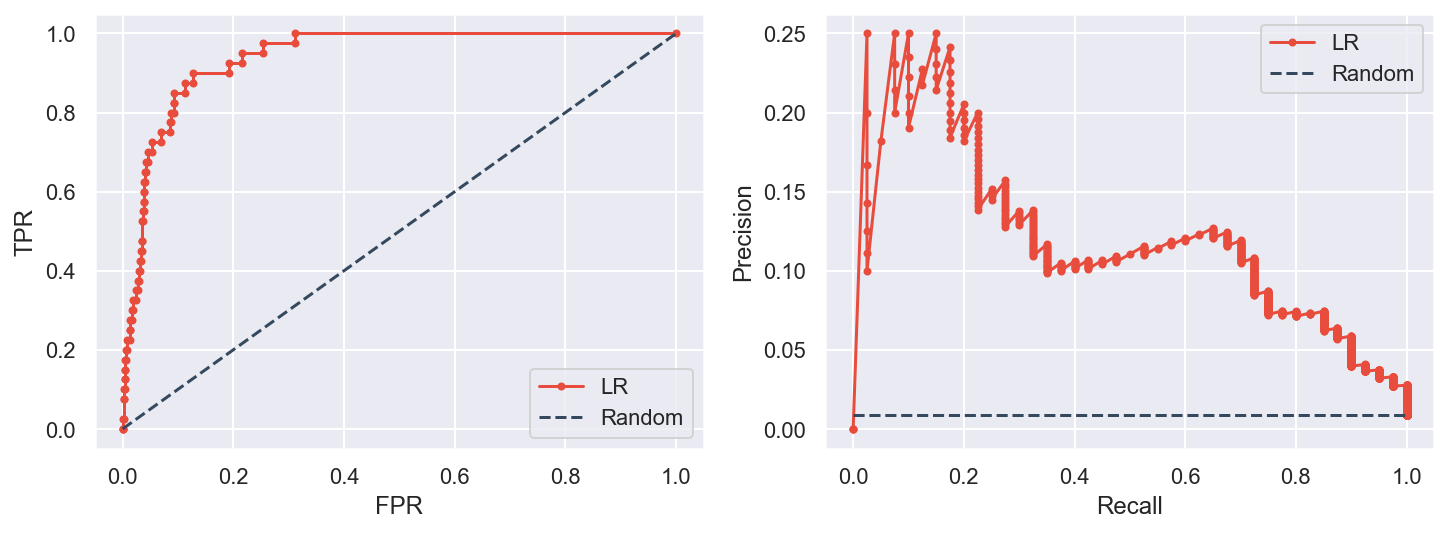


******************* CatBoostClassifier *******************
Best hyper-params: {'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 1, 'learning_rate': 0.04, 'silent': True}
Refit score: precision_score
Best score: 0.98

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4532
           1       0.18      0.28      0.22        40

    accuracy                           0.98      4572
   macro avg       0.59      0.63      0.60      4572
weighted avg       0.99      0.98      0.98      4572

Confusion matrix: 
[[4482   50]
 [  29   11]] 


ROC AUC score: 0.91
P-R AUC score: 0.14


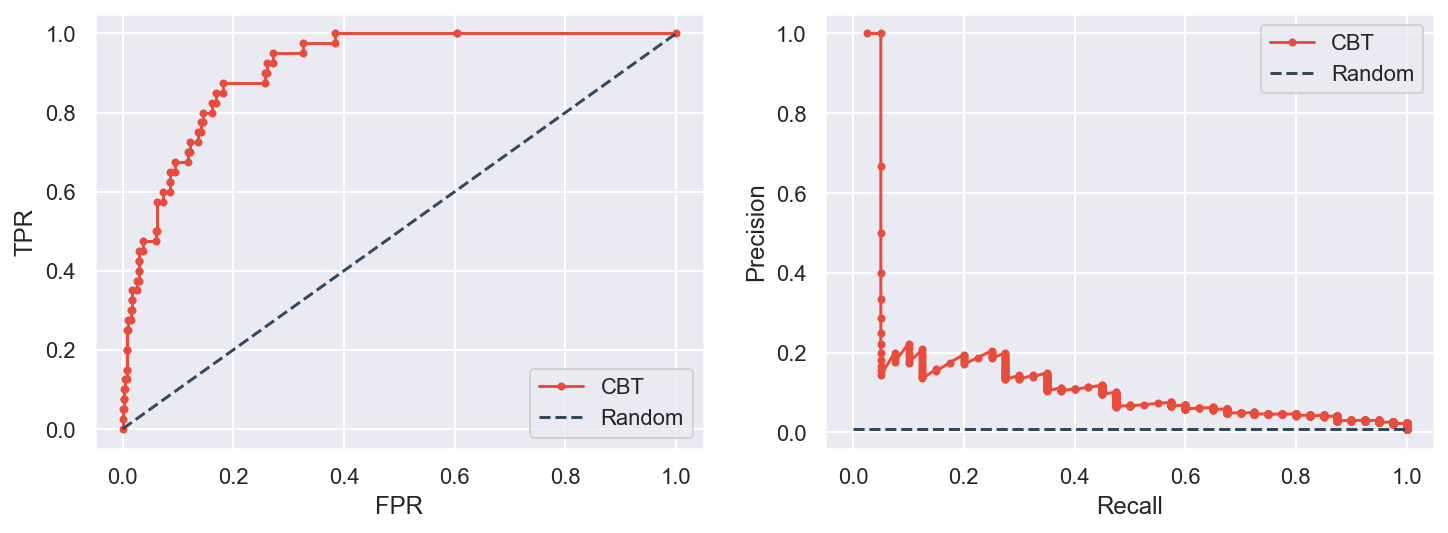


******************* XGBClassifier *******************
Best hyper-params: {'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1}
Refit score: precision_score
Best score: 0.99

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4532
           1       0.18      0.25      0.21        40

    accuracy                           0.98      4572
   macro avg       0.58      0.62      0.60      4572
weighted avg       0.99      0.98      0.98      4572

Confusion matrix: 
[[4485   47]
 [  30   10]] 


ROC AUC score: 0.92
P-R AUC score: 0.12


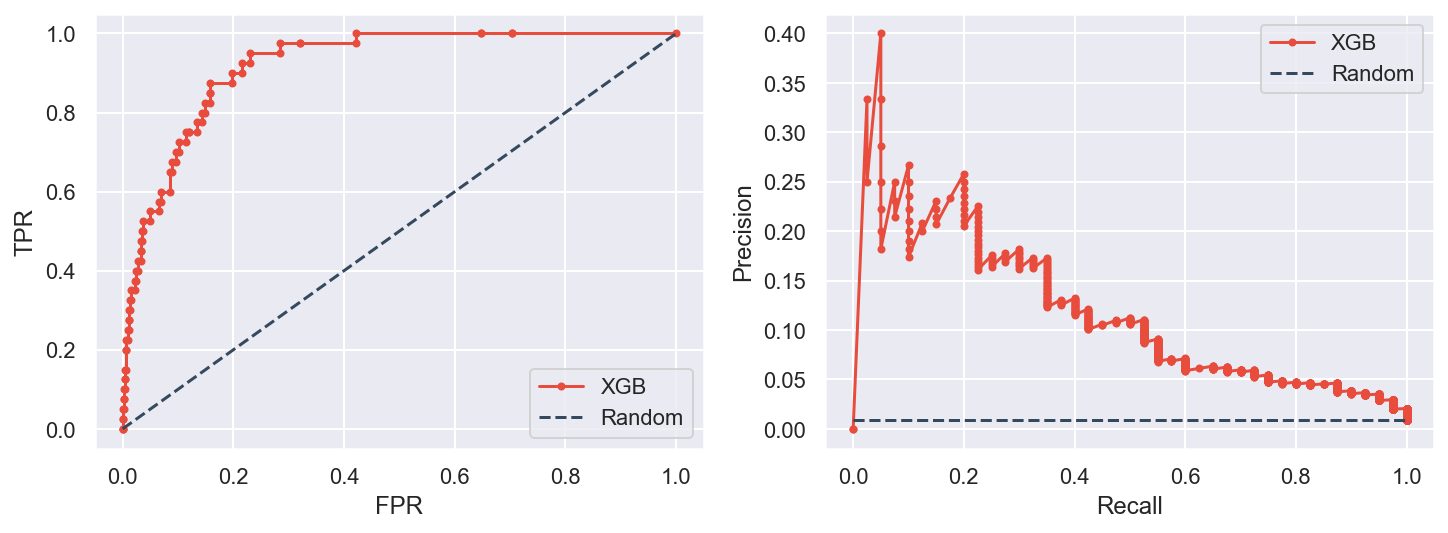

In [48]:
models(classifiers, scorer, refit_score, resampling)